# Lecture 9: Unconstrained optimization, Newton's method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils

from func import Func
from newton import NewtonMultivariateSearch

from IPython.display import display, HTML

# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

## Questions:

- **Homework 08:** Got stuck implementing steepest descent algorithm. How to find $\alpha_k$ using the Secant method? How to choose the two points?
- **Newton Search in nD (see below):** Tried to implement Newton's method for minimisation using solve. It gives different results than when using the inverse of Hessian. Help!
- **Newton Search in nD (see below):** When to break out of the loop for minimisation problems? When are we close to a solution?
- **Homework 09:** How to go about solving exercise 9.1 c)

---
## Multivariate Newton's Method

### Root finding

When we have a single function $f$, the update rule for the Multivariate Newton's Method in root finding is given as:

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \nabla f\left( \mathbf{x}^{(k)} \right)^{-1} f \left( \mathbf{x}^{(k)} \right)
$$

#### Example from the lecture

Sometimes, we are given multiple functions that we need to solve (i.e. find the roots of) iteratively.

For example, let us say we want to solve this system:

\begin{align}
f_1(x_1, x_2) &=  x_1^2 + 2x_2^2 - 22 \\
f_2(x_1, x_2) &= 2x_1^2 +  x_2^2 - 17
\end{align}

We can rewrite the above as vector:

$$
\mathbf{f}(\mathbf{x}) = 
\begin{bmatrix}
x_1^2 + 2x_2^2 - 22 \\
2x_1^2 +  x_2^2 - 17
\end{bmatrix}
$$
where $\mathbf{x} = [x_1, x_2]$

Solving this system means that we have to find roots of the functions i.e., $\mathbf{f}(\mathbf{x})=\mathbf{0}$.

In this case, the update rule becoes:
$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - J\left( \mathbf{x}^{(k)} \right)^{-1} \mathbf{f} \left( \mathbf{x}^{(k)} \right)
$$
where $J$ is the Jacobian matrix given as
$$
J(\mathbf{x}) = 
  \begin{bmatrix}
    \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2}  \\
    \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
  \end{bmatrix}
$$

Let us solve the example above in SymPy using the update rule above. For the initial point, we use $\mathbf{x}^{(0)} = [10, 10]^T$:

In [2]:
# Setup the system
x1, x2 = sy.symbols('x1, x2')
x = (x1, x2)
f1 = x1**2    +  2*x2**2  - 22
f2 = 2*x1**2  +    x2**2  - 17
f = sy.Matrix([f1, f2])
f

⎡  2       2     ⎤
⎢x₁  + 2⋅x₂  - 22⎥
⎢                ⎥
⎢    2     2     ⎥
⎣2⋅x₁  + x₂  - 17⎦

In [3]:
# Set initial point
x_k = (10, 10)

# Compute the Jabobian matrix
J = f.jacobian((x1, x2))

# Compute the Jacobian at x(k)
J_at_x_k = J.subs(dict(zip(x, x_k)))

# Compute the functions at x(k)
f_at_x_k = f.subs(dict(zip(x, x_k)))

# Using the update rule, compute the next point x(k+1)
x_k_plus_1 = sy.Matrix(x_k) - J_at_x_k.inv() * f_at_x_k
x_k_plus_1

⎡26/5⎤
⎢    ⎥
⎢109 ⎥
⎢─── ⎥
⎣ 20 ⎦

In [4]:
utils.format_vector(x_k_plus_1)

"['5.2000', '5.4500']"

---
#### Approach used during the lecture

Notice that in the lecture, Carl used an alternative method which consists of two steps as discussed in the book:

<img src="figures/lecture-09/newtons-method-solve.png" width="600" />


where $F$ is the Jacobian. The only difference is the notation:

<img src="figures/lecture-09/lecture-notation.png" width="150" />


This approach does not require the computation of the inverse of the Jacobian which could be computationally prohibitive for large $n$.

---
### Optimisation

Newton's method (sometimes called the Newton-Raphson method) uses first and second derivatives. The idea behind this method is as follows:

- Given a starting point $\mathbf{x}^{(k)}$, we construct a quadratic approximation $q(\mathbf{x})$ to the objective function $f(\mathbf{x})$ at that point. We can create such an approximation using the Taylor series expansion of $f$ about the point $\mathbf{x}^{(k)}$:

$$
q(\mathbf{x}) = 
    f \left(  \mathbf{x}^{(k)}  \right)
  + \left(\mathbf{x} - \mathbf{x}^{(k)} \right)^T \nabla f \left( \mathbf{x}^{(k)} \right)
  + \frac{1}{2} \left(\mathbf{x} - \mathbf{x}^{(k)} \right)^T F\left(\mathbf{x}^{(k)} \right)  \left(\mathbf{x} - \mathbf{x}^{(k)} \right)
$$
where $F$ is the Hessian.

- We then minimize the approximate (quadratic) function $q(\mathbf{x})$ instead of the original objective function $f(\mathbf{x})$.  This can be done by apply the FONC to $q$ i.e., taking the derivative of $q(\mathbf{x})$ and solving it for when $\nabla q(\mathbf{x}) = \mathbf{0}$ where $\nabla q(\mathbf{x})$ is given as:

$$
\nabla q(\mathbf{x}) = 
     \nabla f \left( \mathbf{x}^{(k)} \right)
   + F\left(\mathbf{x}^{(k)} \right)  \left(\mathbf{x} - \mathbf{x}^{(k)} \right)
$$

- We use the minimizer $\mathbf{x}^{*}$ of the approximate function as the starting point in the next step i.e., $\mathbf{x}^{(1)} = \mathbf{x}^{*}$

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - F \left( \mathbf{x}^{(k)} \right)^{-1} \nabla f \left( \mathbf{x}^{(k)} \right)
$$

- Repeat the procedure iteratively. 

If the objective function $f$ is quadratic, then the approximation $q$ is exact, and the method yields the true minimizer in one step. 

If, on the other hand, the objective function is not quadratic, then the approximation will provide only an estimate of the position of the true minimizer.

---
## Relationship between root finding and minimisation

Newton's method can be seen as an iterative algorithm to find roots. It is often useful when a system of equations do not have a solution but we want to get close to a solution using a iterative method. For example, we know that the following problem does not have a solution:


<img src="figures/lecture-09/four-same-sized-circles-problem.png" width="400" />


This is because we cannot solve the equations with respect to all the variables i.e., we cannot find values for the variables such that all equations become true simultaneously. Solving in this regard means finding roots of system of equations. This is where Newton's method for root finding comes into the picture.

It turns out that the same idea about root finding can be applied to find the minimum of a function $f$. Instead of looking for where $f$ intersects with the $x$-axis, we look at its derivative $f'$. Basically, we try to find the root $f'$. The root of $f'$ gives us the minimum of $f$ as illustrated below:

<img src="figures/lecture-09/newton-root-to-min.png" width="400" />


Another interesting observation is that lines in the $f'$ corresponds to quadratic in $f$ as illustrated in the figure below:

<img src="figures/lecture-09/newton-approximations.png" width="400" />



On the right side, we see that Newton's method approximates a line. As lines in the $f'$ space corresponds to a quadratic function (a polynomial of degree 2) in the $f$ space, the Newton's method approximates a quadratic. The root of the line at each step in the Newton's method corresponds to the approximation of the minimum of a quadratic function.

---
### How does Newton's method compare to steepest descent method

Recall that the method of steepest descent uses only first derivatives (gradients) in selecting a suitable search direction. This strategy is not always the most effective. If higher derivatives are used, the resulting iterative algorithm may perform better than the steepest descent method. Newton's method performs better than the steepest descent method **if the initial point is close to the minimizer**.

---
### Advantages and Disadvantages of Newton's Method

<img src="figures/lecture-09/pros-cons-newton.png" width="500" />


---
### Example 

In [5]:
x1, x2, x3, x4 = sy.symbols('x1, x2, x3, x4')
f = Func((x1 + 10*x2)**2   + 5*(x3-x4)**2  + (x2 - 2*x3)**4 + 10*(x1 - x4)**4, (x1, x2, x3, x4))
f

⎡            2               4              4              2⎤
⎣(x₁ + 10⋅x₂)  + 10⋅(x₁ - x₄)  + (x₂ - 2⋅x₃)  + 5⋅(x₃ - x₄) ⎦

In [7]:
newton_search = NewtonMultivariateSearch(f)
newton_search.find_minimum((3, -1, 0, 1))

Iteration  1: x(1)=['1.5873', '-0.1587', '0.2540', '0.2540'] 
Iteration  2: x(2)=['1.0582', '-0.1058', '0.1693', '0.1693'] 
Iteration  3: x(3)=['0.7055', '-0.0705', '0.1129', '0.1129'] 
Iteration  4: x(4)=['0.4703', '-0.0470', '0.0752', '0.0752'] 
Iteration  5: x(5)=['0.3135', '-0.0314', '0.0502', '0.0502'] 
Iteration  6: x(6)=['0.2090', '-0.0209', '0.0334', '0.0334'] 
Iteration  7: x(7)=['0.1394', '-0.0139', '0.0223', '0.0223'] 
Iteration  8: x(8)=['0.0929', '-0.0093', '0.0149', '0.0149'] 
Iteration  9: x(9)=['0.0619', '-0.0062', '0.0099', '0.0099'] 
Iteration 10: x(10)=['0.0413', '-0.0041', '0.0066', '0.0066'] 
Iteration 11: x(11)=['0.0275', '-0.0028', '0.0044', '0.0044'] 
Iteration 12: x(12)=['0.0184', '-0.0018', '0.0029', '0.0029'] 
Iteration 13: x(13)=['0.0122', '-0.0012', '0.0020', '0.0020'] 
Iteration 14: x(14)=['0.0082', '-0.0008', '0.0013', '0.0013'] 
Iteration 15: x(15)=['0.0054', '-0.0005', '0.0009', '0.0009'] 
Iteration 16: x(16)=['0.0036', '-0.0004', '0.0006', '0.0006'] 
I

⎡ 104857600  ⎤
⎢────────────⎥
⎢219667417263⎥
⎢            ⎥
⎢ -10485760  ⎥
⎢────────────⎥
⎢219667417263⎥
⎢            ⎥
⎢  16777216  ⎥
⎢────────────⎥
⎢219667417263⎥
⎢            ⎥
⎢  16777216  ⎥
⎢────────────⎥
⎣219667417263⎦

---
## Nonlinear Least Squares 



Let us first define the least squares problem:


<img src="figures/lecture-09/def-least-squares-problem.png" width="500" />









where $\mathbf{\hat{x}}$ is the least squares solution and $r_i(\mathbf{x})$ are the residuals:

$$
r_i(\mathbf{x}) = y_i - M(\mathbf{x}, \beta)
$$

An alternative definition of the least squares problem is as follows:

<img src="figures/lecture-09/non-linear-least-squares-problem.png" width="600" />










---
## Curve Fitting


Curve fitting is the process of finding the parameters of a function (model) that best fit some given set of data points.

---
### Example 9.2

<img src="figures/lecture-09/figure-9.2.png" width="600" />










<img src="figures/lecture-09/example-9.2.png" width="600" />










In [8]:
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

num_points = 20
x_start = 0
x_end = 10

A = 2
omega = np.pi/4
phi = 0
noise = 0.2

# Generate data with some noise
x = np.linspace(x_start, x_end, num_points)
y_pure = sinusoid(x, A, omega, phi)
noise_data = np.random.normal(0, noise, y_pure.shape)
y = y_pure + noise_data

# Data for plotting the sinusoid
x_smooth = np.linspace(x_start, x_end, num_points*4)
y_smooth = sinusoid(x_smooth, A, omega, phi)

In [9]:
from scipy import optimize

# Use Levenberg-Marquardt algorithm for curve fitting
optimal_values, covariance = optimize.curve_fit(sinusoid, x, y)

# Generate plot data using the optimal values from the LM algorithm
fitted_A, fitted_omega, fitted_phi = optimal_values

y_fitted = sinusoid(x_smooth, fitted_A, fitted_omega, fitted_phi)

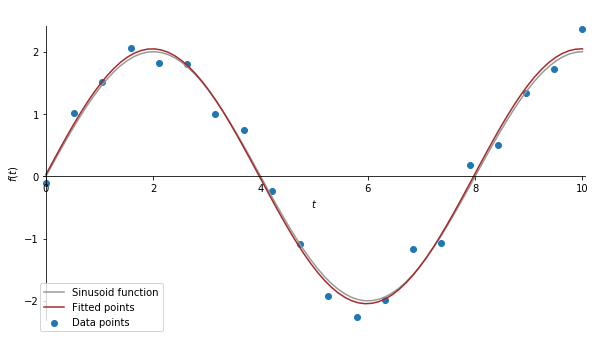

In [10]:
fig, ax = utils.prepare_plot(x, y, xlimit=(-.2, 10.2))

ax.plot(x_smooth, y_smooth, color='#999999', label='Sinusoid function')
ax.scatter(x, y, label='Data points');
ax.plot(x_smooth, y_fitted, color='brown', label='Fitted points');

ax.set_xlabel('$t$')
ax.set_ylabel('$f(t)$')
ax.legend();